<a href="https://colab.research.google.com/github/Sapphirevic/Interpretability/blob/main/ConTranPlus_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SETUP

In [ ]:
#@title Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Changing directory to xxxx
import os
os.chdir("/content/drive/MyDrive/xxx")
print(os.getcwd())

In [ ]:
!pip install --ignore-installed --no-cache-dir blinker statsmodels --upgrade torch==2.6.0

In [ ]:
#@title installing required dependencies
!pip -q install graphviz torchview pyyaml mlflow --quiet dagshub --quiet tsai fastai openpyxl

In [ ]:
pip show torch torchvision

In [ ]:
#@title development imports
from xxx.src.signal_processing import *
from xxx.src.utilities import *
from xxx.src.signal_processing import *
from xxx.qfhd.src.data_utils import *
from xxx.qfhd.src.metrics import *
from xxx.src.ai_utils import LSUVinit

In [ ]:
#@title Visualization imports
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

In [ ]:
#@title TSAI imports
from tsai.models.ROCKET_Pytorch import ROCKET
from tsai.all import *
from functools import partial

In [ ]:
#@title FastAI imports
from fastai.metrics import *
from fastai.callback.all import Callback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

In [ ]:
#@title Scikit-learn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    confusion_matrix, balanced_accuracy_score,
    f1_score, precision_score, recall_score, accuracy_score,
    r2_score, explained_variance_score, mean_squared_log_error, root_mean_squared_error
)

In [ ]:
#@title PyTorch imports
import math
import torch
import torch.fft
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
from torch.nn.utils import weight_norm

In [ ]:
#@title Other imports
import os
import re
import math
import time
import torch
import pickle
import datetime
import warnings
import logging
import pandas as pd
import numpy as np
from datetime import datetime
from torchview import draw_graph
# mlflow and dagshub imports
import mlflow
import dagshub
import mlflow.pytorch
from mlflow.tracking import MlflowClient
from mlflow import log_metric, log_param, log_artifacts, log_figure

# DATA INGESTION

## Helper Functions

In [ ]:
def load_data(metadatapath: str, pickledatapath: str):
  metadata = get_meta_data(metadatapath)
  pickle_data = pd.read_pickle(pickledatapath)
  organized_dict = defaultdict(list)
  for item in pickle_data['file_data']:
      key = '.'.join(item.split('.')[:-2])
      organized_dict[key].append(item)

  filenames = list(organized_dict.values())
  filenames.sort()
  return metadata, pickle_data, filenames

In [ ]:
metadatapath = ''
pickle_datapath = ''
metadata, pickle_data, filenames = load_data(metadatapath, pickle_datapath)
signames = [fname for sublist in filenames for fname in sublist]
patients = set([get_subject_id(signame) for signame in signames])

In [ ]:
#@title Config parameters
config_params = {
    "batch_size": 16,
    "channels":  ['env_scaled', 'env_scaled', 'env_scaled'], #['raw_data', 'env_scaled'],
    "epochs": 1,
    "healthy_threshold": 14,
    "max_whistle_seconds": 20,
    "min_whistle_seconds": 8,
    "model_name": "ConvTranPlus",
    "norm_by_sample": 1,
    "norm_by_var": 1,
    "num_channels": 3,
    "optuna_metric": ['balanced_accuracy_score'],
    "predictor_col": "Strain",
    "preprocessing_type": "Standardize",
    "resample_points": 3000,
    "save_metric": "balanced_accuracy_score",
    "window_length_seconds": 35,
    "prediction_type":"regression",

    # ConvTranPlus-specific parameters from your config
    "c_in": 3,  # Number of input channels
    "c_out": 1,  # Regression output (1 value)
    "seq_len": 3000,  # Matches resample_points
    "d_model": 16,
    "n_heads": 8,
    "dim_ff": 256,
    "abs_pos_encode": "tAPE",
    "rel_pos_encode": "eRPE",
    "encoder_dropout": 0.01,
    "fc_dropout": 0.1,
    "use_bn": True,
    "flatten": True,
    "custom_head": None,
}
hz=50
#dummy size very low to speed up the process

In [ ]:
if config_params["model_name"] == "ConvTranPlus":
    arch_params = {
    "c_in": config_params["c_in"],
    "c_out": config_params["c_out"],
    "seq_len": config_params["seq_len"],
    "d_model": config_params["d_model"],
    "n_heads": config_params["n_heads"],
    "dim_ff": config_params["dim_ff"],
    "abs_pos_encode": config_params["abs_pos_encode"],
    "rel_pos_encode": config_params["rel_pos_encode"],
    "encoder_dropout": config_params["encoder_dropout"],
    "fc_dropout": config_params["fc_dropout"],
    "use_bn": config_params["use_bn"],
    "flatten": config_params["flatten"],
    "custom_head": config_params["custom_head"]
    }
else:
  raise BaseException("Invalid model name")

In [ ]:
#@title Variables
healthy_threshold = config_params["healthy_threshold"]
resample_points = config_params["resample_points"]
channels = config_params["channels"]
min_whistle_seconds = config_params["min_whistle_seconds"]
max_whistle_seconds = config_params["max_whistle_seconds"]
batch_size = config_params["batch_size"]
epochs = config_params["epochs"]
predictor_col = config_params["predictor_col"]
window_length_seconds = config_params[
    "window_length_seconds"
]
test_patients = pickle_data['val_test_splits']['test_subjects']
save_metric = config_params["save_metric"]
preprocessing_type = config_params["preprocessing_type"]
norm_by_var = config_params["norm_by_var"]
norm_by_sample = config_params["norm_by_sample"]
normalize_initialization = True#False
prediction_type = config_params["prediction_type"]
window_length_points = window_length_seconds * hz

# Preprocessing

In [ ]:
error_filenames=[]
x_arr = []
y_arr = []
used_filenames = []
count_insufficient_whistle_time = 0
count_insufficient_signal_length = 0
count_invalid_predictor = 0
count_use4train_false = 0
count_exceptions = 0
count_test = 0
count_removed=0
count_multiple_whistles=0

In [ ]:
for index, signame in enumerate(signames):
    try:
        # print(f"Processing signal {index + 1}/{len(signames)}: {signame}")
        orig_df_columns = channels

        orig_df = pickle_data['file_data'][signame]
        data = orig_df[orig_df_columns].to_numpy()
        print(f"{signame} data.shape = {data.shape}")
        whistle_binary = (orig_df["Category"] == "Whistle").to_numpy()
        if not whistle_binary.size:
            raise IndexError(f"orig_df.Category is empty for filename={signame}.")


        # Identify start and end indices of each contiguous whistle segment
        starts = np.where(np.logical_and(whistle_binary[:-1] == False, whistle_binary[1:] == True))[0] + 1
        ends = np.where(np.logical_and(whistle_binary[:-1] == True, whistle_binary[1:] == False))[0]

        # Calculate durations of each segment
        durations = ends - starts
        if len(starts) > 1 and len(ends):
            count_multiple_whistles +=1

        if len(durations) > 0:
            longest_segment_index = np.argmax(durations)
            first_whistle = starts[longest_segment_index]
            last_whistle= ends[longest_segment_index]

            whistle_length_secs = (last_whistle - first_whistle) / hz
        else:
            first_whistle = np.argmax(whistle_binary)
            last_whistle = len(whistle_binary) - 1 - np.argmax(whistle_binary[::-1])
            whistle_length_secs = (last_whistle - first_whistle) / hz

        mid_whistle = (last_whistle + first_whistle) // 2
        first_index = mid_whistle - window_length_points // 2
        first_index = max(first_index, 0)
        last_index = first_index + window_length_points
        entire_signal = data[first_index:last_index, :]
        # print(f"entire_signal.shape = {entire_signal.shape}")
        # print(f"entire_signal.shape = {entire_signal.shape}")
        if entire_signal.shape[0] != window_length_points:
            # print(
            #     f"Insufficient signal acquired before / after the whistle. Was {round(entire_signal.shape[0]/hz,1)} seconds, but must be at least {round(window_length_points/hz,1)} seconds."
            # )
            count_insufficient_signal_length += 1
            continue

        entire_signal = resample_multichannel_signal(entire_signal, resample_points)

        subject_id = get_subject_id(signame)
        # print(f"subject_id = {subject_id}")

        predictor = metadata.loc[metadata["Subject_ID"] == subject_id][
            predictor_col
        ].iloc[0]
        # print(f"{predictor_col} = {predictor}")
        if type(predictor) is str or math.isnan(predictor):
            print(
                f"Invalid {predictor_col} value of {type(predictor)} {predictor}. Skipping."
            )
            count_invalid_predictor += 1
            continue

        use_4_train = metadata.loc[metadata["Subject_ID"] == subject_id][
            "Use_4_Train"
        ].iloc[0]
        if not use_4_train:
            # print(f"use_4_train = {use_4_train}. Skipping.")
            count_use4train_false += 1
            continue

        x_arr.append(entire_signal)
        if prediction_type == "classification":
            sick = int(predictor < healthy_threshold)
            # print(f"sick = {sick}")
            y_arr.append(sick)
        else:
            y_arr.append(predictor)

        used_filenames.append(signame)
        # print(f"\nlen(used_filenames) = {len(used_filenames)}")

    except (IndexError, KeyError) as error:
        error_filenames.append(signame)
        print(f"error = {error}. Skipping")

In [ ]:
used_patients = list(set([get_subject_id(signame) for signame in used_filenames]))
used_patients.sort()

In [ ]:
counts = {
    "filtered_patients": len(used_patients),
    "original_patients": len(set([get_subject_id(f) for f in signames])),
    "filtered_signals": len(used_filenames),
    "original_signals": len(filenames),
    "insufficient_whistle_time": count_insufficient_whistle_time,
    "insufficient_signal_length": count_insufficient_signal_length,
    "invalid_predictor": count_invalid_predictor,
    "use4train_false": count_use4train_false,
    "exceptions": count_exceptions,
    "test": count_test,
}

In [ ]:
print(f"len(patient_ids) = {len(used_patients)} (# of patients, or N)")
print(f'{counts["original_patients"]} = (# of patients before filtering)')
print(f"len(filenames) = {len(signames)} (# of signals before filtering)")
print(
    f"len(used_filenames) = {len(used_filenames)}/{len(signames)} = {round(len(used_filenames)*100/len(signames))}% (# of signals)"
)
print(
    f"count_insufficient_whistle_time = {count_insufficient_whistle_time}/{len(signames)} = {round(count_insufficient_whistle_time*100/len(signames))}% (whistle length not between {min_whistle_seconds} and {max_whistle_seconds} seconds)"
)
print(
    f"count_insufficient_signal_length = {count_insufficient_signal_length}/{len(signames)} = {round(count_insufficient_signal_length*100/len(signames))}% (signal length not at least {window_length_seconds} seconds)"
)
print(
    f"count_invalid_predictor = {count_invalid_predictor} = {round(count_invalid_predictor*100/len(signames))}% (no {predictor_col} value available)"
)
print(
    f"count_use4train_false = {count_use4train_false}/{len(signames)} = {round(count_use4train_false*100/len(signames))}% (signals the operator marked as data which should not be used for training the AI, such as patients with pacemakers or who failed to properly perform the valsalva maneuver)"
)
print(
    f"count_exceptions = {count_exceptions}/{len(signames)} = {round(count_exceptions*100/len(signames))}% (for situations such as missing data)"
)
print(
    f"count_test = {count_test}/{len(signames)} = {round(count_test*100/len(signames))}% (for testing data)"
)

print(f"Removed filename =  { count_removed}")
print(f"Multiple Whistles={ count_multiple_whistles}")
count_multiple_whistles
X = np.swapaxes(np.array(x_arr), 1, 2)
y = np.array(y_arr)
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")
print(f"np.histogram(y, bins=2) = {np.histogram(y, bins=2)}")

len(patient_ids) = 365 (# of patients, or N)
366 = (# of patients before filtering)
len(filenames) = 969 (# of signals before filtering)
len(used_filenames) = 966/969 = 100% (# of signals)
count_insufficient_whistle_time = 0/969 = 0% (whistle length not between 8 and 20 seconds)
count_insufficient_signal_length = 0/969 = 0% (signal length not at least 35 seconds)
count_invalid_predictor = 0 = 0% (no Strain value available)
count_use4train_false = 3/969 = 0% (signals the operator marked as data which should not be used for training the AI, such as patients with pacemakers or who failed to properly perform the valsalva maneuver)
count_exceptions = 0/969 = 0% (for situations such as missing data)
count_test = 0/969 = 0% (for testing data)
Removed filename =  0
Multiple Whistles=145
X.shape = (966, 3, 3000)
y.shape = (966,)
np.histogram(y, bins=2) = (array([267, 699]), array([ 4., 14., 24.]))


In [ ]:
validation_indices_all_folds = get_validation_indices(pickle_data, get_subject_id, used_filenames)
val_splits = pickle_data['val_test_splits']['val_splits']

In [ ]:
#test_indices = get_test_indices(used_filenames,test_patients)
testing_indices = []

for index, filename in enumerate(used_filenames):

     subject_id = get_subject_id(filename)  # Get the subject ID from the filename

     if subject_id in test_patients:
        testing_indices.append(index)

In [ ]:
if prediction_type == "classification":
    metrics = [
        F1Score(),
        Precision(),
        Recall(),
        accuracy,
        BalancedAccuracy(),
        CohenKappa(),
    ]
    tfms = [None, Categorize()]

else:
    f1_regression = partial(F1_regression, healthy_threshold=healthy_threshold)
    ba_regression = partial(
        balanced_accuracy_regression, healthy_threshold=healthy_threshold
    )
    prec_regression = partial(precision_regression, healthy_threshold=healthy_threshold)
    rec_regression = partial(recall_regression, healthy_threshold=healthy_threshold)

    metrics = [
        f1_regression,
        ba_regression,
        prec_regression,
        rec_regression,
        mse,
        rmse,
        mae,
        msle,
        exp_rmspe,
        ExplainedVariance(),
        R2Score(),
    ]
    tfms = [None, [TSRegression()]]

by_var = False
by_sample = False

if norm_by_sample == 1:
    by_sample = True
if norm_by_var == 1:
    by_var = True

preprocessings = [
    "Standardize",
    "RobustScale",
]

#logging.debug(f"preprocessing type = {preprocessing_type}")
assert preprocessing_type in preprocessings

if preprocessing_type == "Standardize":
    preprocessing = TSStandardize(by_var=by_var, by_sample=by_sample)
elif preprocessing_type == "RobustScale":
    preprocessing = TSRobustScale(by_var=by_var, by_sample=by_sample)
else:
    raise BaseException("Invalid pre processing type")

## Dataloaders

In [ ]:
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

X.shape = (966, 3, 3000)
y.shape = (966,)


In [ ]:
dls_list = []

for fold_indices in validation_indices_all_folds:

    # Get training indices for this fold, excluding test patients
    train_indices = [i for i in range(len(used_filenames)) if i not in fold_indices and i not in testing_indices]

    print(len(train_indices))
    print(len(fold_indices))

    # Create a split for this fold
    splits_fold = [train_indices, fold_indices]

    batch_tfms = [preprocessing]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits_fold)
    # Create DataLoaders for this fold
    dls_fold = TSDataLoaders.from_dsets(
        dsets.train, dsets.valid, splits=splits_fold,
        bs=batch_size, batch_tfms=batch_tfms, num_workers=0
    )

    # Append the DataLoaders for this fold to the list
    dls_list.append(dls_fold)

635
170
639
166
650
155
645
160
651
154


# Architecture Definition

In [ ]:
# https://timeseriesai.github.io/tsai/
model_names = [
    "ConvTranPlus"
]
#logging.debug(f"model_name = {model_name}")
model_name = config_params["model_name"]
assert model_name in model_names

In [ ]:
if model_name ==  "ConvTranPlus":
    model = ConvTranPlus
else:
    raise BaseException("Invalid model name")

In [ ]:
print(f"model = {model_name}")

model = ConvTranPlus


## Attention Weights

In [ ]:
#@title ConvTranPlus attention weights
from tsai.models.ConvTranPlus import Attention_Rel_Scl

# Subclass Attention_Rel_Scl to store attention weights
class Attention_Rel_Scl_With_Weights(Attention_Rel_Scl):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None  # Storage for attention weights

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()  # e.g., (16, 3000, 16)
        n_heads = self.n_heads  # Use instance variable from init (8 in your config)
        d_k = d_model // n_heads  # 16 / 8 = 2

        # Compute Q, K, V
        q = self.query(x)  # (batch_size, seq_len, d_model)
        k = self.key(x)
        v = self.value(x)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)  # (16, 8, 3000, 2)
        k = k.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)

        # Attention scores with relative positional encoding (simplified)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (d_k ** 0.5)  # (16, 8, 3000, 3000)
        attn_weights = torch.softmax(scores, dim=-1)
        self.attn_weights = attn_weights  # Store weights
        attn_weights = self.dropout(attn_weights)

        # Output
        out = torch.matmul(attn_weights, v)  # (16, 8, 3000, 2)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)  # (16, 3000, 16)
        return self.to_out(out)

In [ ]:
# @title Modified ConvTranPlus to manage attention weights
class ConvTranPlusWithAttn(ConvTranPlus):
    def __init__(self, c_in, c_out, seq_len, d_model=16, n_heads=8, dim_ff=256,
                 abs_pos_encode='tAPE', rel_pos_encode='eRPE', encoder_dropout=0.01,
                 fc_dropout=0.1, use_bn=True, flatten=True, custom_head=None):
        super().__init__(c_in=c_in, c_out=c_out, seq_len=seq_len, d_model=d_model, n_heads=n_heads,
                         dim_ff=dim_ff, abs_pos_encode=abs_pos_encode, rel_pos_encode=rel_pos_encode,
                         encoder_dropout=encoder_dropout, fc_dropout=fc_dropout, use_bn=use_bn,
                         flatten=flatten, custom_head=custom_head)
        # Replace attention layer with our custom version
        self.backbone.attention_layer = Attention_Rel_Scl_With_Weights(
            d_model=d_model, seq_len=seq_len, n_heads=n_heads, dropout=encoder_dropout
        )
        self.attn_weights_storage = []  # List to store weights during training

    def forward(self, x):
        out = super().forward(x)
        # Store attention weights after each forward pass
        attn_weights = self.backbone.attention_layer.attn_weights
        if attn_weights is not None:
            self.attn_weights_storage.append(attn_weights.detach().cpu())
        return out

    def get_attention_weights(self):
        return self.attn_weights_storage

In [ ]:
# @title Updated plot_attention_weights
def plot_attention_weights(attention_weights, layer_idx=0, batch_idx=0, head_idx=0):
    """
    Plots the attention weights for the single attention layer.
    layer_idx is fixed at 0 since there's only one attention layer.
    """
    if not attention_weights:
        print("No attention weights provided to plot.")
        return
    attn_weights_single = attention_weights[batch_idx][head_idx].detach().cpu().numpy()  # (3000, 3000)
    plt.figure(figsize=(10, 10))
    plt.imshow(attn_weights_single, cmap='viridis')
    plt.title(f"Self-Attention Map - Layer {layer_idx}, Batch {batch_idx}, Head {head_idx}")
    plt.colorbar()
    plt.show()

In [ ]:
# @title Updated attention_hook
def attention_hook(module, input, output):
    """
    Hook function to capture and log attention weights from Attention_Rel_Scl_With_Weights.
    """
    if hasattr(module, 'attn_weights') and module.attn_weights is not None:
        print(f"Captured attention weights of shape: {module.attn_weights.shape}")
        print(f"Min: {module.attn_weights.min().item():.4f}")
        print(f"Max: {module.attn_weights.max().item():.4f}")
        print(f"Mean: {module.attn_weights.mean().item():.4f}")

In [ ]:
# @title Updated register_attention_hooks
def register_attention_hooks(model):
    """
    Registers a forward hook on the single Attention_Rel_Scl_With_Weights layer.
    """
    print(f"Registering hook for attention_layer: {model.backbone.attention_layer}")
    model.backbone.attention_layer.register_forward_hook(attention_hook)

In [ ]:
#@title Fold model creation
from tsai.models.ConvTranPlus import ConvTranPlus  # For reference, but we'll use our custom class

models_list = []  # List to store the models for each fold

# Loop through each fold and create a model for that fold
for dls_fold in dls_list:
    model_args = [k for k, v in arch_params.items() if k in config_params]
    print(model_args)
    model_kwargs = {}
    for arg in model_args:
        if arg in arch_params:
            model_kwargs[arg] = arch_params[arg]

    print(model_kwargs)
    # Create the model for the current fold with fold-specific keyword arguments
    # Use ConvTranPlusWithAttn instead of base ConvTranPlus
    model_fold = ConvTranPlusWithAttn(**model_kwargs)

    # Append the model to the list
    models_list.append(model_fold)

['c_in', 'c_out', 'seq_len', 'd_model', 'n_heads', 'dim_ff', 'abs_pos_encode', 'rel_pos_encode', 'encoder_dropout', 'fc_dropout', 'use_bn', 'flatten', 'custom_head']
{'c_in': 3, 'c_out': 1, 'seq_len': 3000, 'd_model': 16, 'n_heads': 8, 'dim_ff': 256, 'abs_pos_encode': 'tAPE', 'rel_pos_encode': 'eRPE', 'encoder_dropout': 0.01, 'fc_dropout': 0.1, 'use_bn': True, 'flatten': True, 'custom_head': None}
['c_in', 'c_out', 'seq_len', 'd_model', 'n_heads', 'dim_ff', 'abs_pos_encode', 'rel_pos_encode', 'encoder_dropout', 'fc_dropout', 'use_bn', 'flatten', 'custom_head']
{'c_in': 3, 'c_out': 1, 'seq_len': 3000, 'd_model': 16, 'n_heads': 8, 'dim_ff': 256, 'abs_pos_encode': 'tAPE', 'rel_pos_encode': 'eRPE', 'encoder_dropout': 0.01, 'fc_dropout': 0.1, 'use_bn': True, 'flatten': True, 'custom_head': None}
['c_in', 'c_out', 'seq_len', 'd_model', 'n_heads', 'dim_ff', 'abs_pos_encode', 'rel_pos_encode', 'encoder_dropout', 'fc_dropout', 'use_bn', 'flatten', 'custom_head']
{'c_in': 3, 'c_out': 1, 'seq_len

In [ ]:
print(f"Length of dls_list: {len(dls_list)}")
print(f"Length of models_list: {len(models_list)}")
for fold, dls_fold in enumerate(dls_list):
    if fold == 0:
        print(f"Fold {fold + 1} / {len(dls_list)}")
        register_attention_hooks(models_list[fold])

Length of dls_list: 5
Length of models_list: 5
Fold 1 / 5
Registering hook for attention_layer: Attention_Rel_Scl_With_Weights(
  (key): Linear(in_features=16, out_features=16, bias=False)
  (value): Linear(in_features=16, out_features=16, bias=False)
  (query): Linear(in_features=16, out_features=16, bias=False)
  (dropout): Dropout(p=0.01, inplace=False)
  (to_out): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
output_directory = "/content/drive/MyDrive/Projects"
model_title = f"{model_name}_model_graph"
output_path = f"{output_directory}/{model_title}"

dummy_input = dls_list[0].one_batch()[0]
graph = draw_graph(models_list[0], graph_name=model_name, input_data=dummy_input, expand_nested=True)
graph.visual_graph.render(output_path, format="png")
# graph.visual_graph

In [ ]:
print(f"\nModel: {model_name}")
print(f"Model type: {type(models_list[0])}")
print(f"Number of model parameters: {sum(p.numel() for p in models_list[0].parameters())}")
print(f"Model fold parameters: {models_list[0].parameters}")


Model: ConvTranPlus
Model type: <class '__main__.ConvTranPlusWithAttn'>
Number of model parameters: 61097
Model fold parameters: <bound method Module.parameters of ConvTranPlusWithAttn(
  (backbone): ConvTranBackbone(
    (embed_layer): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 7), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (embed_layer2): Sequential(
      (0): Conv2d(64, 16, kernel_size=(3, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (abs_position): tAPE(
      (dropout): Dropout(p=0.01, inplace=False)
    )
    (attention_layer): Attention_Rel_Scl_With_Weights(
      (key): Linear(in_features=16, out_features=16, bias=False)
      (value): Linear(in_features=16, out_features=16, bias=False)
      (query): Linear(in_features=1

In [ ]:
# Iterate through the model parameters
for name, param in models_list[0].named_parameters():
    if "Linear" in name or "mha" in name or "pwff" or "attn_norm" in name:
        print(f"{name} - Max: {param.data.abs().max():.4f}, Mean: {param.data.abs().mean():.4f}")

backbone.embed_layer.0.weight - Max: 0.3762, Mean: 0.1924
backbone.embed_layer.0.bias - Max: 0.3710, Mean: 0.1778
backbone.embed_layer.1.weight - Max: 1.0000, Mean: 1.0000
backbone.embed_layer.1.bias - Max: 0.0000, Mean: 0.0000
backbone.embed_layer2.0.weight - Max: 0.0722, Mean: 0.0360
backbone.embed_layer2.0.bias - Max: 0.0672, Mean: 0.0379
backbone.embed_layer2.1.weight - Max: 1.0000, Mean: 1.0000
backbone.embed_layer2.1.bias - Max: 0.0000, Mean: 0.0000
backbone.attention_layer.relative_bias_table - Max: 0.0000, Mean: 0.0000
backbone.attention_layer.key.weight - Max: 0.2482, Mean: 0.1272
backbone.attention_layer.value.weight - Max: 0.2499, Mean: 0.1256
backbone.attention_layer.query.weight - Max: 0.2474, Mean: 0.1211
backbone.attention_layer.to_out.weight - Max: 1.0000, Mean: 1.0000
backbone.attention_layer.to_out.bias - Max: 0.0000, Mean: 0.0000
backbone.LayerNorm.weight - Max: 1.0000, Mean: 1.0000
backbone.LayerNorm.bias - Max: 0.0000, Mean: 0.0000
backbone.LayerNorm2.weight - Max:

### Training Helpers

In [ ]:
def plot_confusion_matrix_regression_all(
    train_labels,
    train_prediction,
    test_labels,
    test_prediction,
    valid_labels,
    valid_prediction,
    healthy_threshold,
    title,
):
    # Calculate metrics
    mae_train, rmse_train, ba_train = get_metrics(
        train_prediction, train_labels, healthy_threshold
    )
    mae_test, rmse_test, ba_test = get_metrics(
        test_prediction, test_labels, healthy_threshold
    )
    mae_valid, rmse_valid, ba_valid = get_metrics(
        valid_prediction, valid_labels, healthy_threshold
    )

    # Set plotting style
    plt.style.use("dark_background")
    plot_width_px = 1800
    plot_height_px = 800
    pixels_per_inch = 60
    plt.rcParams["figure.dpi"] = pixels_per_inch
    plt.rcParams["font.family"] = ["sans-serif"]
    plt.rcParams["font.size"] = 18
    plt.rcParams["legend.fontsize"] = 12
    plt.rcParams["figure.figsize"] = [
        plot_width_px / pixels_per_inch,
        plot_height_px / pixels_per_inch,
    ]
    plt.rcParams["lines.linewidth"] = 3
    plt.rcParams["lines.antialiased"] = True
    plt.rcParams["grid.alpha"] = 0.5
    plt.rcParams["axes.grid"] = True

    # Create subplots
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad=3.0)
    fig.suptitle(title)

    # Plot data
    axs[0, 0].scatter(train_labels, train_prediction, c="blue", marker="x")
    axs[0, 0].set_title(
        "Train: "
        + "RMSE: "
        + str(rmse_train)
        + " MAE: "
        + str(mae_train)
        + " B.A: "
        + str(ba_train)
    )
    axs[0, 1].scatter(test_labels, test_prediction, c="red", marker="x")
    axs[0, 1].set_title(
        "Test: "
        + "RMSE: "
        + str(rmse_test)
        + " MAE: "
        + str(mae_test)
        + " B.A: "
        + str(ba_test)
    )
    axs[1, 0].scatter(valid_labels, valid_prediction, c="green", marker="x")
    axs[1, 0].set_title(
        "Valid: "
        + "RMSE: "
        + str(rmse_valid)
        + " MAE: "
        + str(mae_valid)
        + " B.A: "
        + str(ba_valid)
    )
    axs[1, 1].scatter(train_labels, train_prediction, c="blue", marker="x")
    axs[1, 1].scatter(test_labels, test_prediction, c="red", marker="x")
    axs[1, 1].scatter(valid_labels, valid_prediction, c="green", marker="x")
    axs[1, 1].set_title("Combined")

    # Configure plot axes
    for ax in axs.flat:
        ax.plot([i for i in range(0, healthy_threshold * 2)])
        ax.axis("square")
        ax.set(xlabel="Actual Value", ylabel="Predicted Value")
        ax.axhline(y=healthy_threshold, color="r", linestyle="-")
        ax.axvline(x=healthy_threshold, color="y", linestyle="-")

    # Set limits
    plt.xlim([0, healthy_threshold * 2])
    plt.ylim([0, healthy_threshold * 2])

    # Create output directory if it doesn't exist
    output_dir = ''
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    plot_file = os.path.join(output_dir, f"{title}_Confusion_matrix.png")
    plt.savefig(plot_file)

    # Log the figure with MLflow
    mlflow.log_artifact(plot_file, artifact_path="Confusion_matrix_plots")

    return plt

In [ ]:
def transform_make_prediction(learner, x, y):
    """
    Transform input data and make predictions using a ConvTranPlus learner.

    Args:
        learner: A tsai Learner object containing the ConvTranPlusWithAttn model.
        x: Input data (e.g., NumPy array) of shape (batch_size, c_in, seq_len), e.g., (16, 3, 3000).
        y: Target data (e.g., NumPy array) of shape (batch_size, c_out), e.g., (16, 1).

    Returns:
        preds: Predictions as a NumPy array of shape (batch_size, c_out), e.g., (16, 1).
        y: Original target data unchanged.
    """
    # Convert input to PyTorch tensor if not already
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(np.asarray(x)).float()  # Shape: (batch_size, c_in, seq_len)

    # Ensure input matches expected shape (batch_size, c_in, seq_len)
    if x.dim() != 3:
        raise ValueError(f"Expected x with 3 dimensions (batch_size, c_in, seq_len), got shape {x.shape}")

    # Move to device (if model is on GPU)
    device = next(learner.model.parameters()).device
    x = x.to(device)

    # Get predictions using learner.get_X_preds (returns NumPy array)
    preds = learner.get_X_preds(x)  # Shape: (batch_size, c_out), e.g., (16, 1)

    # Return predictions and original y unchanged
    return preds, y

In [ ]:
def get_metrics(predictions, target, healthy_threshold):
    mae = round(mean_absolute_error(target, predictions), 2)
    rmse = round(root_mean_squared_error(target, predictions), 2)

    threshold_target = []
    threshold_prediction = []

    for i in range(len(target)):
        threshold_target.append(int(target[i] < healthy_threshold))
        threshold_prediction.append(int(predictions[i] < healthy_threshold))

    ba_score = round(balanced_accuracy_score(threshold_target, threshold_prediction), 2)

    return mae, rmse, ba_score

In [ ]:
def inspect_model_output(learner, dataloader):
    for batch in dataloader:
        inputs, targets = batch
        outputs = learner.model(inputs)
        print(f"Output type: {type(outputs)}, Output shape: {outputs.shape if hasattr(outputs, 'shape') else 'tuple'}")
        break

In [ ]:
def debug_training_step(model, dataloader):
    # Get first batch
    xb, yb = next(iter(dataloader))
    print(f"Input batch shape: {xb.shape}")
    print(f"Target batch shape: {yb.shape}")

    # Get the output from the model
    out = model(xb)  # Changed from learner.model to model directly
    print(f"Model output shape: {out.shape}")

    # Calculate loss
    mse_loss = nn.MSELoss()
    try:
        loss = mse_loss(out, yb)
        print(f"MSE Loss: {loss}")
    except RuntimeError as e:
        print(f"Error in MSE calculation: {e}")

    # Print shapes of tensors involved in loss calculation
    print(f"out.shape: {out.shape}")
    print(f"yb.shape: {yb.shape}")

# Training

In [ ]:
from itertools import product
# Clear cached data
torch.cuda.empty_cache()

# Initialize variables to accumulate results
all_train_labels = []
all_train_predictions = []
all_test_labels = []
all_test_predictions = []
all_valid_labels = []
all_valid_predictions = []

# Get the current date and time
now = datetime.now()
date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S")
percentiles = [80, 85, 90, 95]
learners = []  # Create an empty list to store the learners
cbs=[
            ShowGraphCallback2(),
            PredictionDynamics(),
            SaveModelCallback(monitor="balanced_accuracy_regression"),
            EarlyStoppingCallback(monitor="_rmse", comp=np.less, patience=50),
]

learning_rates = [1e-4]#, 1e-4]
weight_decays = [0.01]#, 0.001, 0.0001]

weight_decay_batchnorm_bias = False

# Targeted Fold Training

## a. Fold A (Fold 0)

## Weights stored during training

In [ ]:
desired_fold = 0  # Set to 0, 1, 2, 3, or 4 for Fold 1-5; None for all folds

for lr, weight_decay in product(learning_rates, weight_decays):
    for fold, dls_fold in enumerate(dls_list):
        if desired_fold is not None and fold != desired_fold:
            continue  # Skip all folds except the desired one
        print(f"Fold {fold + 1} / {len(dls_list)}")
        model_fold = models_list[fold]  # Already ConvTranPlusWithAttn from models_list

        # Register hooks to capture attention weights
        register_attention_hooks(model_fold)

        # Training setup
        opt_func = partial(Adam, lr=lr, wd=weight_decay)
        learner = Learner(
            dls_fold, model_fold,
            metrics=metrics, cbs=cbs,
            opt_func=opt_func
        ).to_fp16()

        # Train the model for this fold
        print(f"Training Fold {fold + 1} with lr={lr}, wd={weight_decay}, config={arch_params}")
        start = time.perf_counter()
        learner.fit_one_cycle(epochs, lr_max=lr)  # Train for all epochs
        end = time.perf_counter()
        training_time = end - start
        print(f"Fold {fold + 1} training time with lr={lr}: {training_time}")

        # Capture attention weights after training
        model_fold.eval()
        sample_input = dls_fold.one_batch()[0]  # Get a batch from the dataloader
        with torch.no_grad():
            model_fold(sample_input)  # Forward pass to capture weights

        attention_weights = model_fold.get_attention_weights()  # Retrieve stored weights
        if attention_weights:
            print(f"Number of captured attention weight tensors: {len(attention_weights)}")
            print(f"Shape of last attention weights: {attention_weights[-1].shape}")
            # Plot self-attention maps for the first 3 batches/heads
            #for i in range(min(3, len(attention_weights))):
            #    plot_attention_weights(attention_weights, layer_idx=0, batch_idx=i, head_idx=i)
        else:
            print("No attention weights captured. Ensure the model is executed correctly.")

In [ ]:
#@title Inference
# After training, or as a standalone block
model_fold = models_list[0]  # Fold 1 model (already trained)
model_fold.eval()
sample_input = dls_list[0].one_batch()[0]  # Get a batch from Fold 1 dataloader
with torch.no_grad():
    model_fold(sample_input)  # Forward pass to ensure weights are populated

attention_weights = model_fold.get_attention_weights()  # Retrieve stored weights
if attention_weights:
    print(f"Number of captured attention weight tensors: {len(attention_weights)}")
    print(f"Shape of last attention weights: {attention_weights[-1].shape}")
    # Visualize the first 3 batches and 3 heads
    for batch_idx in range(min(3, len(attention_weights))):
        for head_idx in range(min(3, 8)):  # Limit to 3 heads out of 8
            batch_weights = attention_weights[batch_idx]  # Shape: (batch_size, n_heads, seq_len, seq_len)
            attn_weights_single = batch_weights[:, head_idx, :, :]  # Shape: (batch_size, 3000, 3000)
            attn_weights_avg = attn_weights_single.mean(dim=0).detach().cpu().numpy()  # Shape: (3000, 3000)
            plt.figure(figsize=(10, 10))
            plt.imshow(attn_weights_avg, cmap='viridis')
            plt.title(f"Self-Attention Map - Fold 1, Batch {batch_idx}, Head {head_idx}")
            plt.colorbar()
            plt.show()
else:
    print("No attention weights captured.")

# Weights stored post-training

After clearing, number of tensors: 0
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0029
Mean: 0.0003
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0029
Mean: 0.0003
Generated weights for batch 1, shape: torch.Size([16, 8, 3000, 3000])
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0026
Mean: 0.0003
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0026
Mean: 0.0003
Generated weights for batch 2, shape: torch.Size([16, 8, 3000, 3000])
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0035
Mean: 0.0003
Captured attention weights of shape: torch.Size([16, 8, 3000, 3000])
Min: 0.0000
Max: 0.0035
Mean: 0.0003
Generated weights for batch 3, shape: torch.Size([16, 8, 3000, 3000])
Number of captured attention weight tensors: 3
Shape of last attention weights: torch.Size([16, 8, 3000, 3000])


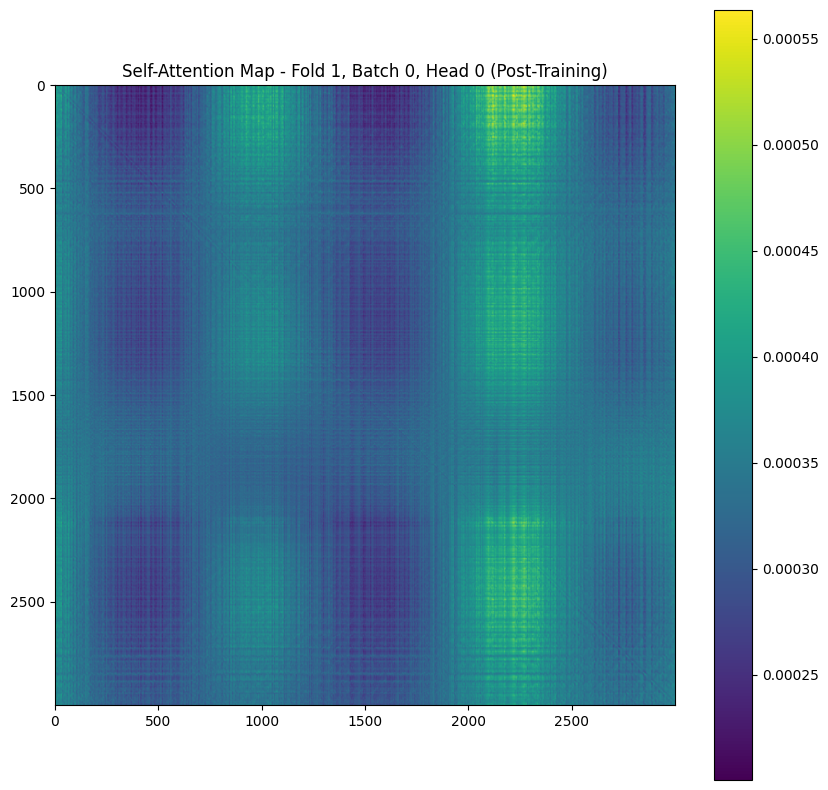

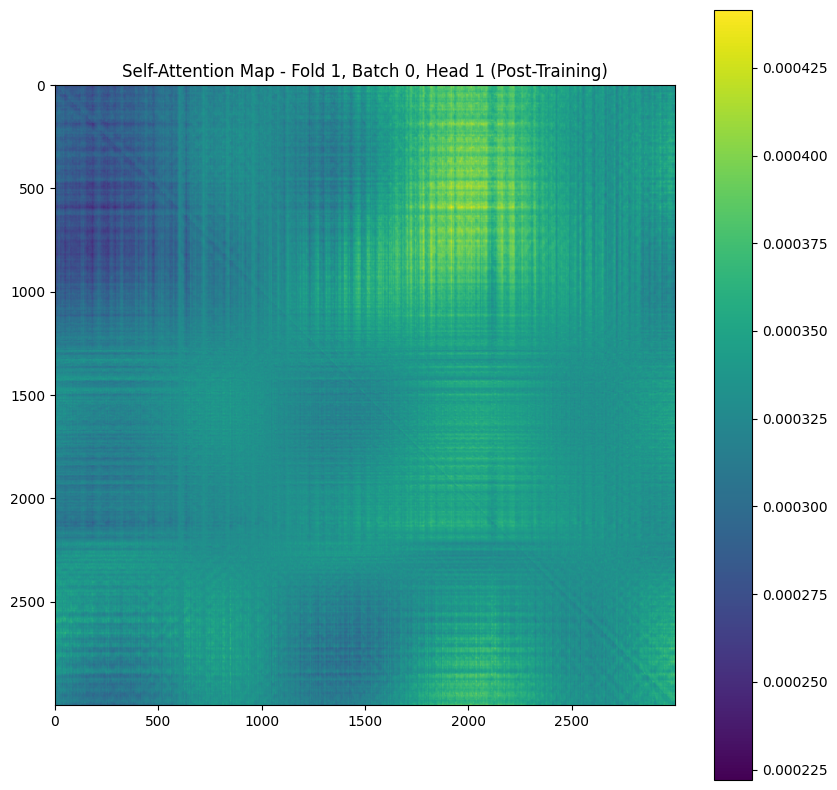

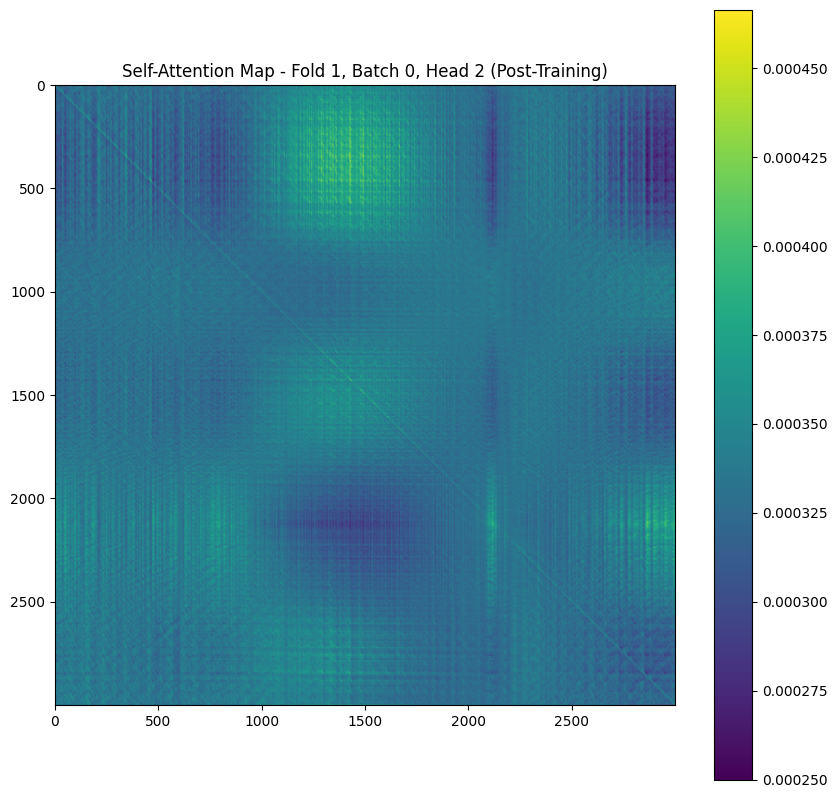

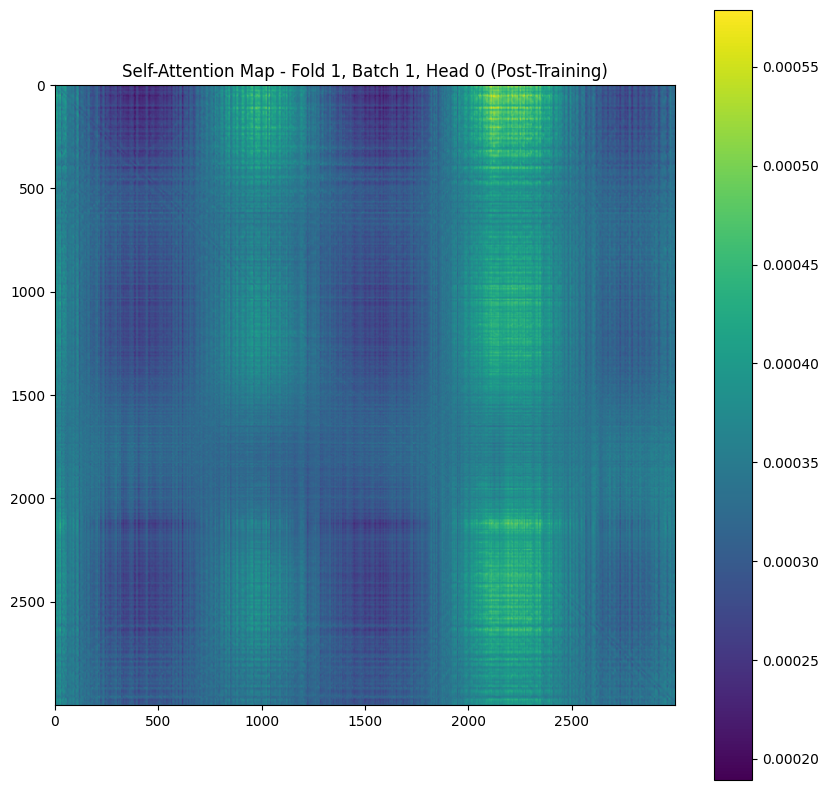

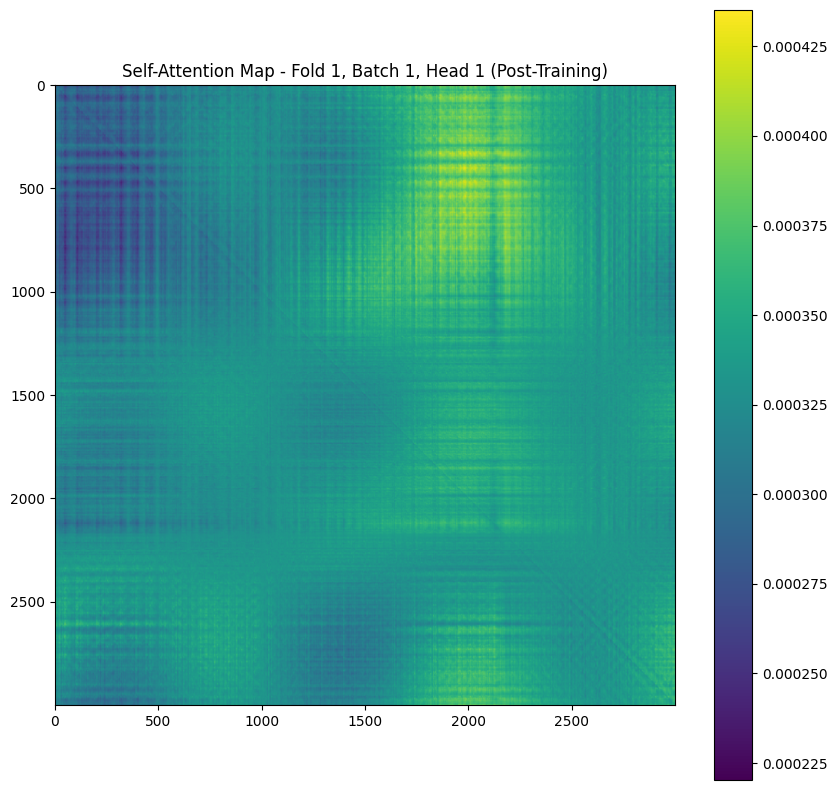

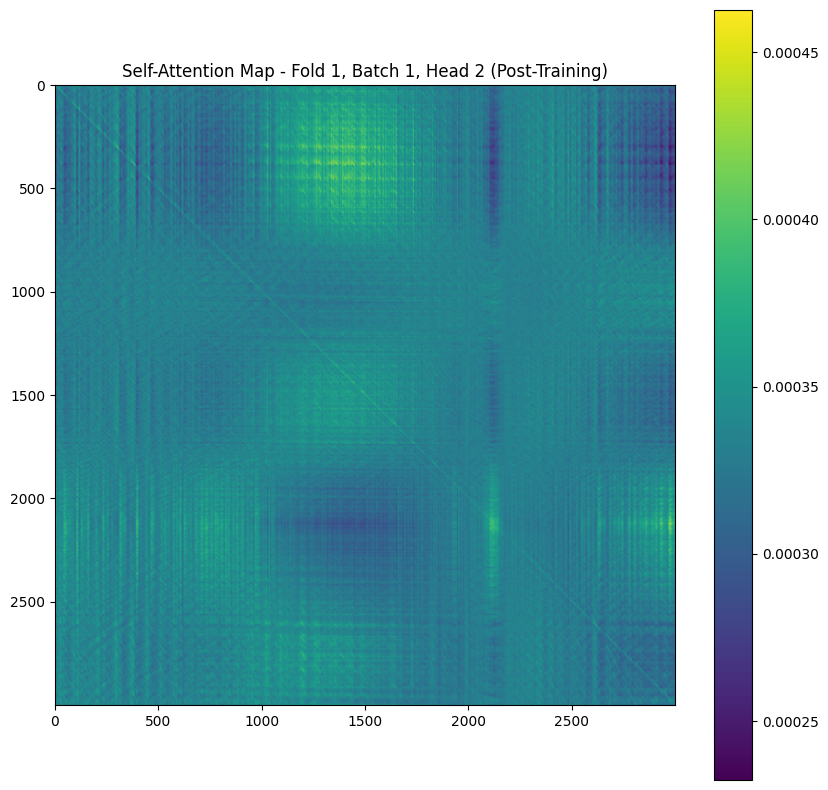

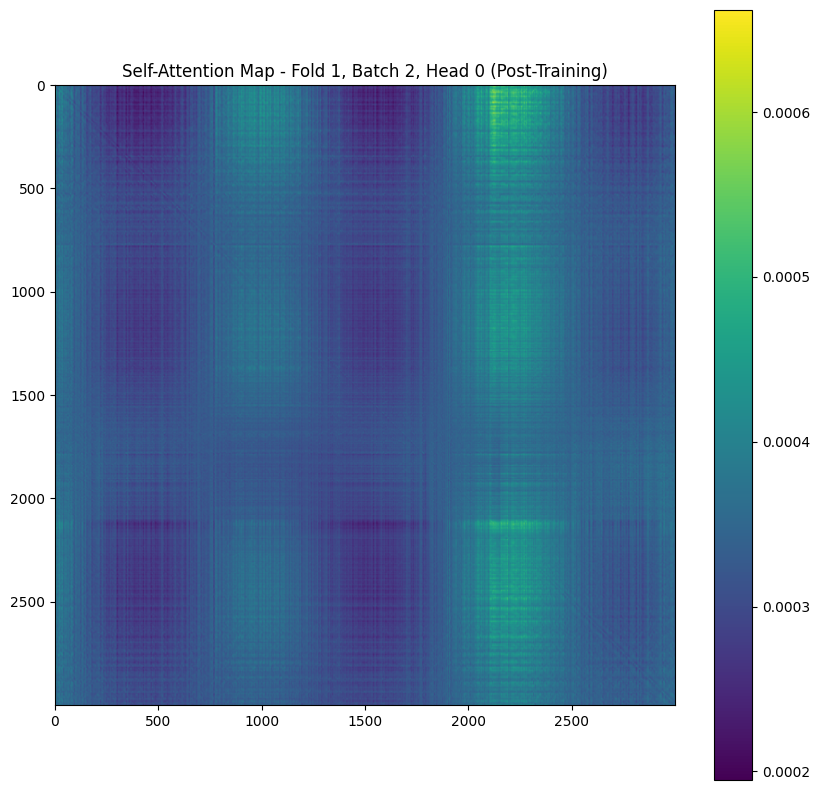

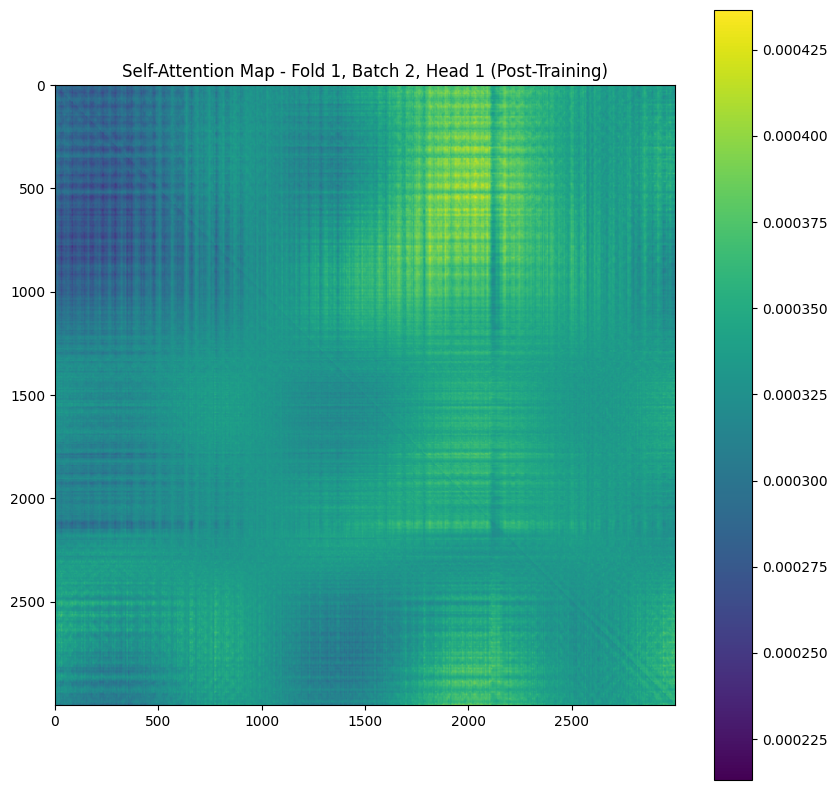

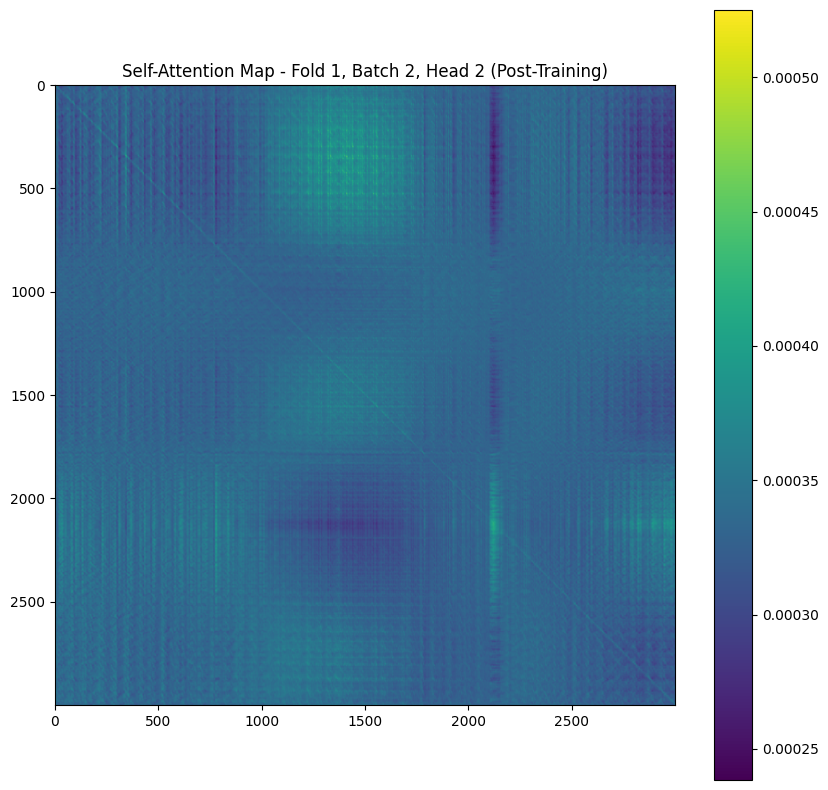

In [ ]:
import torch
import matplotlib.pyplot as plt

# Step 1: Get the trained model for Fold 1
model_fold = models_list[0]  # Fold 1 model (already trained)
model_fold.eval()  # Set to evaluation mode (dropout off)

# Step 2: Clear existing weights from training
model_fold.attn_weights_storage = []  # Reset storage to ensure we only use post-training weights
print(f"After clearing, number of tensors: {len(model_fold.get_attention_weights())}")

# Step 3: Generate new attention weights after training
dls_fold = dls_list[0]  # Fold 1 DataLoader
num_batches_to_generate = 3  # Generate weights for 3 batches
with torch.no_grad():
    for i, batch in enumerate(dls_fold.train):  # Use training DataLoader
        if i >= num_batches_to_generate:
            break
        sample_input = batch[0]  # Get input tensor (e.g., shape [16, 3, 3000])
        model_fold(sample_input)  # Forward pass to generate and store weights
        print(f"Generated weights for batch {i+1}, shape: {model_fold.attn_weights_storage[-1].shape}")

# Step 4: Retrieve and visualize the new weights
attention_weights = model_fold.get_attention_weights()
if attention_weights:
    print(f"Number of captured attention weight tensors: {len(attention_weights)}")
    print(f"Shape of last attention weights: {attention_weights[-1].shape}")
    # Visualize all generated batches (3) and 3 heads per batch
    for batch_idx in range(len(attention_weights)):
        for head_idx in range(min(3, 8)):  # Limit to 3 heads out of 8
            batch_weights = attention_weights[batch_idx]  # Shape: (batch_size, n_heads, seq_len, seq_len)
            attn_weights_single = batch_weights[:, head_idx, :, :]  # Shape: (batch_size, 3000, 3000)
            attn_weights_avg = attn_weights_single.mean(dim=0).detach().cpu().numpy()  # Shape: (3000, 3000)
            plt.figure(figsize=(10, 10))
            plt.imshow(attn_weights_avg, cmap='viridis')
            plt.title(f"Self-Attention Map - Fold 1, Batch {batch_idx}, Head {head_idx} (Post-Training)")
            plt.colorbar()
            plt.show()
else:
    print("No attention weights captured.")